# Electric dipole moment of a flux qubit

This notebook shows how to calculate the electric dipole moment of a 3JJ flux qubit using scqubits (v. 3.2.0)

Based on examples from: https://scqubits.readthedocs.io/en/latest/guide/qubits/flux_qubit.html

The detailed derivation of the dipole moment expression can be found at the PhD thesis: *Superinductive Ultrastrong Couplings in Superconducting quantum Circuits*, Alba Torras-Coloma, 2025.

Author: Alba Torras-Coloma

QCT lab (Barcelona) June 2025

## Start importing packages and setting up plotting format

In [1]:
import scqubits
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# File containing functions to convert units to GHz
import conversion_energies as tools

In [2]:
# Set general plotting style
mpl.rc('text', usetex = True)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Computer Modern",
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'legend.fontsize': 8
 })

params = {'text.latex.preamble': [r'\usepackage{siunitx}', 
    r'\usepackage{sfmath}', r'\sisetup{detect-family = true}',
    r'\usepackage{amsmath}', r'\usepackage{textcomp}', 
    r'\usepackage{upgreek}']}   
#plt.rcParams.update(params) 

%matplotlib inline

## Set qubit parameters and initiallize the fluxqubit instance

In [3]:
# Set qubit parameters 4.5GHz
alpha = 0.58
Jc    = 2.4     # uA/um^2
area  = 0.0784  # um^2
Csh   = 7.3     # fF
Sc    = 50      # fF/um^2
Cc    = 0.447    # fF

Convert qubit parameters to energies in GHz

In [4]:
EJ = tools.calculate_Ej(Jc, area)
Ec = tools.calculate_Ec(Sc * area)
Ec_alph = tools.calculate_Ec(Sc * area * alpha + Csh)
Ec_cc = tools.calculate_Ec(Cc)

Let's consider that the system has the same capacitive coupling Cc on node 1 and 2

In [5]:
fluxqubit = scqubits.FluxQubit(EJ1 = EJ,
                              EJ2 = EJ,
                              EJ3 = alpha*EJ,
                              ECJ1 = Ec,
                              ECJ2 = Ec,
                              ECJ3 = Ec_alph,
                              ECg1 = Ec_cc,
                              ECg2 = Ec_cc,
                              ng1 = 0.0,
                              ng2 = 0.0,
                              flux = 0.5,
                              ncut = 12)

fluxqubit.hamiltonian(energy_esys=True)

array([[-104.51801508,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,  -98.9385551 ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,  -87.54490291,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,  -74.80446417,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
         -61.36594805,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,  -55.33968031]])

## Sweeps vs charge and flux

We sweep the charge and flux to determine afterwards the electric dipole moment vs these two variables

### Charge sweep

In [6]:
# Define the range of charge sweep
ng2_range = np.linspace(-5, 5, 101)

# Run the simulation
spec_ch = fluxqubit.get_spectrum_vs_paramvals('ng2', ng2_range, evals_count=3, subtract_ground=True, 
                                           get_eigenstates=True, filename=None, num_cpus=None)


Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

Let's plot the spectrum of the system vs charge in island 2

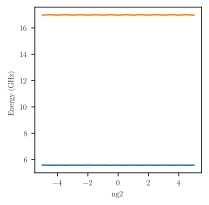

In [7]:
fig, ax = plt.subplots(figsize=(3,3))

ax.plot(ng2_range, spec_ch.energy_table[:,1:])
ax.set_xlabel("ng2")
ax.set_ylabel("Energy (GHz)")

plt.show()

### Sweep the hamiltonian vs flux

In [8]:
# Try vs flux
flux_range = np.linspace(0.47, 0.53, 101)

spec = fluxqubit.get_spectrum_vs_paramvals('flux', flux_range, evals_count=3, subtract_ground=True, get_eigenstates=True, 
                                           filename=None, num_cpus=None)

Spectral data:   0%|          | 0/101 [00:00<?, ?it/s]

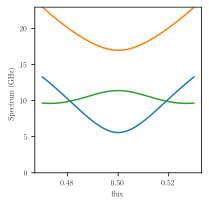

In [9]:
fig, ax = plt.subplots(figsize=(3,3))

ax.plot(flux_range, spec.energy_table[:, 1:])
ax.plot(flux_range, spec.energy_table[:, 2] - spec.energy_table[:, 1])

ax.set_xlabel("flux")
ax.set_ylabel("Spectrum (GHz)")
ax.set_ylim([0, np.max(spec.energy_table[0, :])])
plt.show()

## Dipole vs flux

We will use the results of the simulation done in previous cells to plot d01 vs flux. For details on the derived relations between charges, check the PhD thesis: *Superinductive Ultrastrong Couplings in Superconducting quantum Circuits*, Alba Torras-Coloma, 2025.

The dipole moment can be calculated using, 
$$ 
d_{01} = \frac{2e \left[ C_{J3} <0| \hat{n}_1 \otimes \mathbf{I}_2 |1> + (C_{J1} + C_{g1} + C_{J3})<1|\mathbf{I}_1 \otimes \hat{n}_2 |1> \right]}{(C_{J1} + C_{g1} + C_{J3})(C_{J2} + C_{g2} + C_{J3}) - C_{J3}^2}
$$

### Functions to calculate the dipole

In [10]:
def global_prefactor_without_e(Ec1, Ec2, Ec3, Ecg1, Ecg2):
    # Compute the corresponding capacitances (fF)
    Cj1 = tools.calculate_C(Ec1)
    Cj2 = tools.calculate_C(Ec2)
    Cj3 = tools.calculate_C(Ec3)
    Cg1 = tools.calculate_C(Ecg1)
    Cg2 = tools.calculate_C(Ecg2)
    
    # Compute individual parentesis 
    sum1 = Cj1 + Cg1 + Cj3
    sum2 = Cj2 + Cg2 + Cj3
    
    fraction = Ec1 * 4 * Cj1 / (sum1 * sum2 - Cj3**2)  # GHz / fF
    
    return fraction

In [14]:
def d01_SI(glob_pref_no_e, n1_overlap, n2_overlap, Ec1, Ecg1, Ec3):
    # Compute the corresponding capacitances (fF)
    Cj1 = tools.calculate_C(Ec1)
    Cj3 = tools.calculate_C(Ec3)
    Cg1 = tools.calculate_C(Ecg1)
    
    total = glob_pref_no_e * (n1_overlap * Cj3 + n2_overlap * (Cj1 + Cg1 + Cj3))  # in GHz
    
    # Convert now to Joules
    total_SI = tools.convert_GHz_to_J(total) / tools.E
    
    return total_SI

In [15]:
def overlap_n_op(vect0, vect1, n_op):
    "Calculates overlap with N operator"
    res = np.dot(np.dot((vect0.T).conjugate(), n_op), vect1)
                 
    return res

### Calculate the dipole vs flux

In [16]:
# Calculate the dipole for each flux iteration
d01_all_f = []
d02_all_f = []
d12_all_f = []

for ii in range(len(spec.state_table)):
    # Calculate overlaps
    ov1 = overlap_n_op(spec.state_table[ii][:,0], spec.state_table[ii][:,1], fluxqubit.n_1_operator(energy_esys=False))
    ov2 = overlap_n_op(spec.state_table[ii][:,0], spec.state_table[ii][:,1], fluxqubit.n_2_operator(energy_esys=False))
    
    ov1_2 = overlap_n_op(spec.state_table[ii][:,0], spec.state_table[ii][:,2], fluxqubit.n_1_operator(energy_esys=False))
    ov2_2 = overlap_n_op(spec.state_table[ii][:,0], spec.state_table[ii][:,2], fluxqubit.n_2_operator(energy_esys=False))
    
    ov1_12 = overlap_n_op(spec.state_table[ii][:,1], spec.state_table[ii][:,2], fluxqubit.n_1_operator(energy_esys=False))
    ov2_12 = overlap_n_op(spec.state_table[ii][:,1], spec.state_table[ii][:,2], fluxqubit.n_2_operator(energy_esys=False))
    
    # Calculate the big prefactor coming from the determinant
    big_pref_f = global_prefactor_without_e(Ec, Ec, Ec_alph, 1e10, Ec_cc)
    
    # Compute d01
    d01_all_f.append(np.abs((d01_SI(big_pref_f, ov1, ov2, Ec, 1e10, Ec_alph))))
    d02_all_f.append(np.abs((d01_SI(big_pref_f, ov1_2, ov2_2, Ec, 1e10, Ec_alph))))
    d12_all_f.append(np.abs((d01_SI(big_pref_f, ov1_12, ov2_12, Ec, 1e10, Ec_alph))))

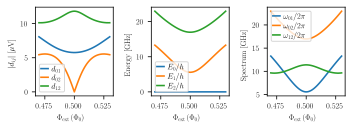

In [17]:
fig, ax = plt.subplots(1,3, figsize=(5.1,1.9))
# Transition matrix elements
ax[0].plot(flux_range, np.array(d01_all_f)*1e6,  linewidth=1.6, label='$d_{01}$')
ax[0].plot(flux_range, np.array(d02_all_f)*1e6,  linewidth=1.6, label='$d_{02}$')
ax[0].plot(flux_range, np.array(d12_all_f)*1e6,  linewidth=1.6, label='$d_{12}$')

# Qubit energy
ax[1].plot(flux_range, spec.energy_table[:, 0],linewidth=1.6, label=r'$E_{0}/h$')
ax[1].plot(flux_range, spec.energy_table[:, 1],  linewidth=1.6, label=r'$E_{1}/h$')
ax[1].plot(flux_range, spec.energy_table[:, 2],  linewidth=1.6, label=r'$E_{2}/h$')

# Qubit spectrum
ax[2].plot(flux_range, spec.energy_table[:, 1] - spec.energy_table[:, 0],  linewidth=1.6, label=r'$\omega_{01}/2\pi$')
ax[2].plot(flux_range, spec.energy_table[:, 2] - spec.energy_table[:, 0], linewidth=1.6, label=r'$\omega_{02}/2\pi$')
ax[2].plot(flux_range, spec.energy_table[:, 2]-spec.energy_table[:, 1],linewidth=1.6, label=r'$\omega_{12}/2\pi$')


ax[0].set_xlabel(r'$\Phi_{\mathrm{ext}}\, (\Phi_0)$')
ax[0].set_ylabel(r'$|d_{ij}|$ [$\mathrm{\mu}$V]')
ax[0].legend(loc='lower left', frameon = True, handlelength=0.9, handletextpad=0.4, labelspacing = 0.2, borderpad=0.2)

ax[1].set_xlabel(r'$\Phi_{\mathrm{ext}}\, (\Phi_0)$')
ax[1].set_ylabel('Energy [GHz]')
ax[1].legend(loc='lower left', frameon = True, handlelength=0.9, handletextpad=0.4, labelspacing = 0.2, borderpad=0.2)

ax[2].set_xlabel(r'$\Phi_{\mathrm{ext}}\, (\Phi_0)$')
ax[2].set_ylabel(r'Spectrum [GHz]')
ax[2].legend(loc='upper left', frameon = True, handlelength=0.9, handletextpad=0.4, labelspacing = 0.2, borderpad=0.2)
plt.tight_layout()
plt.show()

## Dipole vs charge

We will use the results of the simulation done in previous cells to plot d01 vs charge (ng2)

In [18]:
# Calculate the dipole for each flux iteration
d01_all_ch = []
d02_all_ch = []
d12_all_ch = []

for ii in range(len(spec_ch.state_table)):
    # Calculate overlaps
    ov1 = overlap_n_op(spec_ch.state_table[ii][:,0], spec_ch.state_table[ii][:,1], fluxqubit.n_1_operator(energy_esys=False))
    ov2 = overlap_n_op(spec_ch.state_table[ii][:,0], spec_ch.state_table[ii][:,1], fluxqubit.n_2_operator(energy_esys=False))
    
    ov1_2 = overlap_n_op(spec_ch.state_table[ii][:,0], spec_ch.state_table[ii][:,2], fluxqubit.n_1_operator(energy_esys=False))
    ov2_2 = overlap_n_op(spec_ch.state_table[ii][:,0], spec_ch.state_table[ii][:,2], fluxqubit.n_2_operator(energy_esys=False))
    
    ov1_12 = overlap_n_op(spec_ch.state_table[ii][:,1], spec_ch.state_table[ii][:,2], fluxqubit.n_1_operator(energy_esys=False))
    ov2_12 = overlap_n_op(spec_ch.state_table[ii][:,1], spec_ch.state_table[ii][:,2], fluxqubit.n_2_operator(energy_esys=False))
    
    # Calculate the big prefactor coming from the determinant
    big_pref_ch = global_prefactor_without_e(Ec, Ec, Ec_alph, 1e10, Ec_cc)
    
    # Compute d01
    d01_all_ch.append(np.abs(d01_SI(big_pref_ch, ov1, ov2, Ec, 1e10, Ec_alph)))
    d02_all_ch.append(np.abs(d01_SI(big_pref_ch, ov1_2, ov2_2, Ec, 1e10, Ec_alph)))
    d12_all_ch.append(np.abs(d01_SI(big_pref_ch, ov1_12, ov2_12, Ec, 1e10, Ec_alph)))

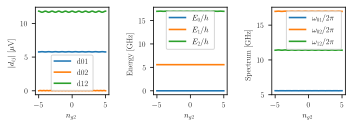

In [19]:
fig, ax = plt.subplots(1,3, figsize=(5.1,1.9))
# Transition matrix elements
ax[0].plot(ng2_range, np.array(d01_all_ch)*1e6, linewidth=1.6, label='d01')
ax[0].plot(ng2_range, np.array(d02_all_ch)*1e6, linewidth=1.6, label='d02')
ax[0].plot(ng2_range, np.array(d12_all_ch)*1e6, linewidth=1.6, label='d12')

ax[0].set_xlabel(r'$n_{g2}$')
ax[0].set_ylabel(r'$|d_{ij}|$ [$\mathrm{\mu}$V]')
ax[0].legend(frameon = True)
#ax[0].set_ylim([-0.2e-6, 6e-6])

# Qubit energy
ax[1].plot(ng2_range, spec_ch.energy_table[:, 0],linewidth=1.6, label=r'$E_{0}/h$')
ax[1].plot(ng2_range, spec_ch.energy_table[:, 1], linewidth=1.6, label=r'$E_{1}/h$')
ax[1].plot(ng2_range, spec_ch.energy_table[:, 2], linewidth=1.6, label=r'$E_{2}/h$')

ax[1].set_xlabel(r'$n_{g2}$')
ax[1].set_ylabel(r'Energy [GHz]')
ax[1].legend(frameon = True)

# Qubit spectrum
ax[2].plot(ng2_range, spec_ch.energy_table[:, 1] - spec_ch.energy_table[:, 0],linewidth=1.6, label=r'$\omega_{01}/2\pi$')
ax[2].plot(ng2_range, spec_ch.energy_table[:, 2] - spec_ch.energy_table[:, 0], linewidth=1.6, label=r'$\omega_{02}/2\pi$')
ax[2].plot(ng2_range, spec_ch.energy_table[:, 2] - spec_ch.energy_table[:, 1], linewidth=1.6, label=r'$\omega_{12}/2\pi$')

ax[2].set_xlabel(r'$n_{g2}$')
ax[2].set_ylabel(r'Spectrum [GHz]')
ax[2].legend(frameon = True)
#ax[2].set_ylim([0, 11])


plt.tight_layout()
plt.show()